In [2]:
import pandas as pd
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns

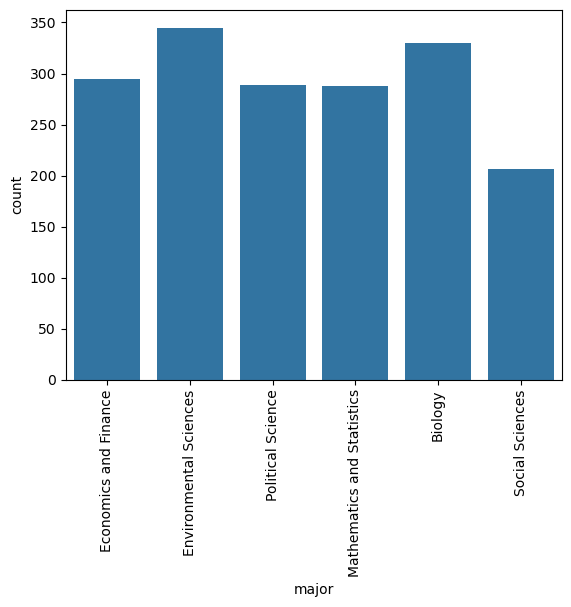

In [3]:
#%%Cargar la base de datos
data = pd.read_csv(r"C:\Users\Daniela de la Torre\OneDrive\Escritorio\4to_Semestre\Analisis Estadistico Multivariado\students (1).csv")
# Filtrar los estudiantes graduados
#Se filtra lo que se quiere saber
graduated_student = data[data['graduated'] == 1] #aqui va el grupo que se quiere conocer con respecto a x
sns.countplot(data = graduated_student, x='major') #lo que se quiere conocer con respecto al grupo filtrado
plt.xticks(rotation = 90)
plt.show()

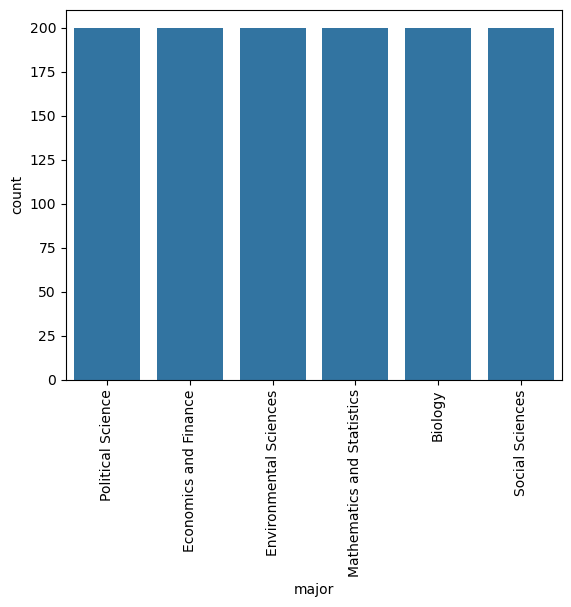

In [14]:
#%%
specialties = ['Political Science', 'Economics and Finance', 'Environmental Sciences', 'Mathematics and Statistics', 'Biology', 'Social Sciences'] #se hace una lista de las carreras que queremos analizar
sample_size = 200 

sample_list = []  #se guardan aqui los datos guardados para cada especialidad
# Se toma una muestra aleatoria de 200 estudiantes por especialidad

#Se filtra el DataFrame graduated_student para seleccionar solo los estudiantes que tienen esa especialidad en la columna major.
#Se usa .sample(sample_size) para tomar 200 muestras aleatorias de cada especialidad.
#Se agrega cada subconjunto a sample_list.
for specialty in specialties:
    sample = graduated_student[graduated_student['major'] == specialty].sample(sample_size)
    sample_list.append(sample)

# Concatenar todas las muestras en un único DataFrame
sample = pd.concat(sample_list)


sns.countplot(data = sample, x = 'major')
plt.xticks(rotation = 90)
plt.show()

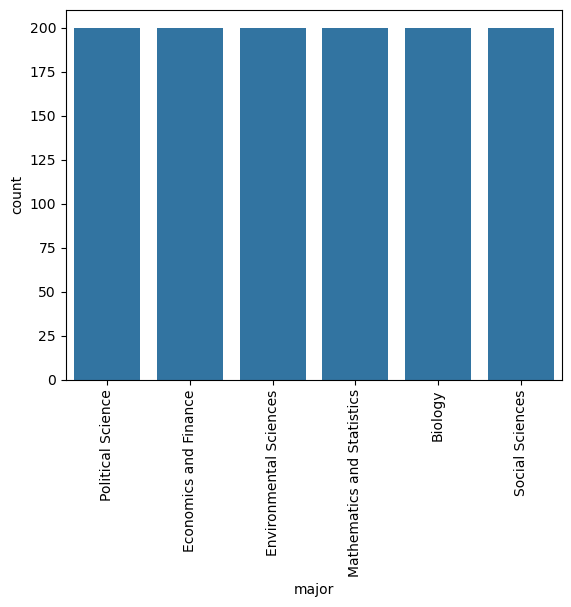

In [5]:
#%%
specialties = ['Political Science', 'Economics and Finance', 'Environmental Sciences', 'Mathematics and Statistics', 'Biology', 'Social Sciences']
sample_size = 200

sample_list = []  

for specialty in specialties:
    sample = graduated_student[graduated_student['major'] == specialty].sample(sample_size)
    sample_list.append(sample)

# Concatenar todas las muestras en un único DataFrame
sample = pd.concat(sample_list)


sns.countplot(data = sample, x = 'major')
plt.xticks(rotation = 90)
plt.show()

In [15]:
#%% Cumplimiento de supuestos
#Normalidad prueba de Shapiro-Wilk
#Ho:Normalidad(p>0.05)
#H1: No normalidad (p<0.05)
normality_test = pg.normality(sample, dv = 'salary', group = 'major') #dv= variable dependiente, group = variable independiente
#Se hace la prueba de normalidad para cada especialidad y se guarda en un DataFrame
print("Prueba de Normalidad (Shapiro-Wilk):\n", normality_test)

Prueba de Normalidad (Shapiro-Wilk):
                                    W      pval  normal
major                                                 
Political Science           0.987764  0.083071    True
Economics and Finance       0.990666  0.223068    True
Environmental Sciences      0.994657  0.699147    True
Mathematics and Statistics  0.991683  0.309859    True
Biology                     0.980106  0.006158   False
Social Sciences             0.994562  0.684786    True


In [7]:
#%%Homocedasticidad prueba de Levene (sin normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample, dv='salary', 
                    group='major',method='levene')

,W,pval,equal_var
levene,11.087098,1.857655e-10,False


In [8]:
#%%Homocedasticidad prueba de Bartlett (con normalidad)
#Ho:Homocedasticidad (p>0.05)
#H1: No Homocedasticidad (p<0.05)
pg.homoscedasticity(sample, dv='salary', 
                    group='major',method='bartlett')

,T,pval,equal_var
bartlett,74.841657,1.003839e-14,False


In [16]:
#%% One way ANOVA
# Typ = 2 calcula las sumas de cuadrados de tipo II, que es apropiado para ANOVAs balanceados y desequilibrados
model =ols('salary ~ major', data=sample).fit() #izquierda:dependiente, derecha:independiente
#Se ajusta el modelo ANOVA a los datos
anova_table = sm.stats.anova_lm(model,typ=2)
print("\nTabla ANOVA:")
print(anova_table)
#Si p-value < 0.05, se concluye que hay una diferencia significativa entre al menos dos grupos (carreras).
#Si p-value >= 0.05, no hay evidencia suficiente para afirmar que las carreras afectan el salario de manera significativa.


Tabla ANOVA:
                sum_sq      df           F         PR(>F)
major     5.884924e+10     5.0  185.620895  2.489775e-146
Residual  7.570914e+10  1194.0         NaN            NaN


In [17]:
#%%Comparación múltiple Prueba de Tukey
comp = mc.MultiComparison(sample['salary'],sample['major'])
post_hoc_res = comp.tukeyhsd()
print("\nComparaciones múltiples (Tukey):")
print(post_hoc_res.summary())
#Si p < 0.05 y Rechaza H0 = True → Hay evidencia estadística de que los salarios de las dos carreras comparadas son diferentes. Si p >= 0.05 y Rechaza H0 = False → No hay diferencia significativa entre esas dos carreras en cuanto a salario.
#Ejemplo:Si Economía y Biología tienen p = 0.001 y Rechaza H0 = True, significa que sus salarios son significativamente diferentes. Si Matemáticas y Ciencias Sociales tienen p = 0.543 y Rechaza H0 = False, significa que no hay evidencia de diferencia salarial entre ellas.


Comparaciones múltiples (Tukey):
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
          group1                     group2             meandiff  p-adj     lower       upper    reject
-------------------------------------------------------------------------------------------------------
                   Biology      Economics and Finance   1316.4418 0.5632   -956.4507   3589.3343  False
                   Biology     Environmental Sciences -11041.2618    0.0 -13314.1543  -8768.3693   True
                   Biology Mathematics and Statistics    308.7714 0.9989   -1964.121   2581.6639  False
                   Biology          Political Science -11871.3775    0.0   -14144.27   -9598.485   True
                   Biology            Social Sciences -16267.9647    0.0 -18540.8572 -13995.0723   True
     Economics and Finance     Environmental Sciences -12357.7035    0.0  -14630.596 -10084.8111   True
     Economics and Finance Mat

In [18]:
#%% Two ways ANOVA
#Ho:m1=m2=m3+.... (p>0.05)
#H1: mi dif mj (p<0.05)
model =ols('salary ~ major + gender + major:gender ', data=sample).fit() #aqui hay una interaccion entre las variables independientes
#Se ajusta el modelo ANOVA a los datos
anova_table = sm.stats.anova_lm(model,typ=2)
print("\nTabla ANOVA:")
print(anova_table)


Tabla ANOVA:
                    sum_sq      df           F         PR(>F)
major         4.090134e+10     5.0  175.967244  3.218091e-140
gender        1.952221e+10     1.0  419.945879   3.721271e-80
major:gender  9.598450e+08     5.0    4.129481   1.008351e-03
Residual      5.522709e+10  1188.0         NaN            NaN


In [19]:
#%% Interacción entre variables
model =ols('salary ~ major:gender', data=sample).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print("\nTabla ANOVA:")
print(anova_table)


Tabla ANOVA:
                    sum_sq      df           F         PR(>F)
major:gender  7.933130e+10    11.0  155.137284  1.016878e-220
Residual      5.522709e+10  1188.0         NaN            NaN


In [20]:
#%% Prueba de Tukey (HSD)
interaction_groups = "Major" + sample.major.astype(str) + " & " + "Gender" + sample.gender.astype(str)
comp = mc.MultiComparison(sample["salary"], interaction_groups)
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res.summary())
#Si p < (menor)0.05 y Rechaza H0 = True, significa que hay una diferencia estadísticamente significativa entre dos combinaciones de carrera y género.
#Si p >= (mayor) 0.05 y Rechaza H0 = False, significa que no hay evidencia estadística de diferencia salarial entre esos grupos.

                                              Multiple Comparison of Means - Tukey HSD, FWER=0.05                                              
                    group1                                         group2                       meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------------------------------------------------------------------------------
                   MajorBiology & GenderFemale                      MajorBiology & GenderMale  10792.1094    0.0   7588.0012  13996.2177   True
                   MajorBiology & GenderFemale      MajorEconomics and Finance & GenderFemale    137.2352    1.0  -3664.6875   3939.1579  False
                   MajorBiology & GenderFemale        MajorEconomics and Finance & GenderMale  10765.0233    0.0   7676.1537  13853.8928   True
                   MajorBiology & GenderFemale     MajorEnvironmental Sciences & GenderFemale  -9781.3985    0.0  -13404.511  -6158.2861